# Xarray-spatial
### User Guide: Proximity (Distance) tools
-----
The Distance tools allow you to perform analysis that accounts for either straight-line (Euclidean) or weighted distance. The following table lists the available Distance tools and provides a brief description of each:

[Proximity Distance](#Proximity-Distance)

[Proximity Allocation](#Proximity-Allocation): Calculates distance allocation for each cell to the provided sources based on straight-line distance, cost distance, true surface distance, as well as vertical and horizontal cost factors.

[Proximity Direction](#Proximity-Direction)

-----------


#### Let's use datashader to render our images...

In [1]:
import numpy as np
import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

## Proximity Distance

The `xrspatial.proximity` function operates on a given aggregate to produce a new distance aggregate based on target values and a distance metric. The values in the new aggregate will be the distance (according to the given metric) between each array cell (pixel) and the nearest target value in the source aggregate.

A powerful feature of `proximity` is that you can target specific values, the `target_values` parameter, in the aggregate for distance calculation, while others are ignored. If it is not set, then the default targets will be all non-zero pixels. Play with the parameter and see the difference of using `target_values=[1,2,3,4]` vs. default option. 

   ##### Load data and create `ds.Canvas`

In [2]:
from xrspatial import proximity
import pandas as pd


df = pd.DataFrame({
   'x': [-13, -11, -5, 4, 9, 11, 18, 6],
   'y': [-13, -5, 0, 10, 7, 2, 5, -5],
   'id': [1, 2, 3, 4, 5, 6, 7, 8]
})

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H,
                x_range=(-20, 20), y_range=(-20, 20))

   ##### Create Proximity Aggregate
   
   - Use `Canvas.points` to create an `xarray.DataArray` that all non-zero cells have an unique value that represent for a separate region/source.
   - Calculate proximity to nearest target using `xrspatial.proximity`

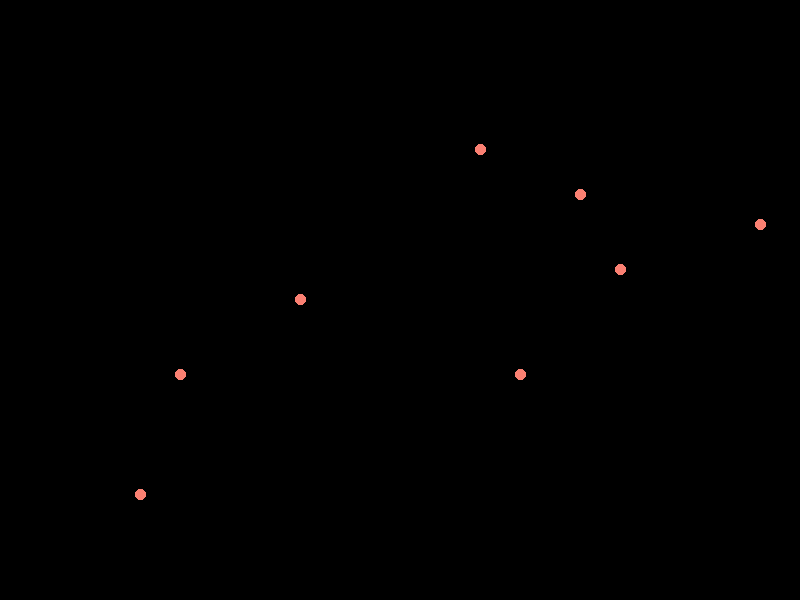

In [3]:
# all non-zero cells have an unique value that represent for a separate region
points_agg = cvs.points(df, x='x', y='y', agg=ds.min('id'))
points_agg.data[~np.isfinite(points_agg.data)] = 0
points_agg = (points_agg).astype(int)

points_shaded = dynspread(shade(points_agg, cmap=['salmon',  'salmon']),
                          threshold=1,
                          max_px=5)
set_background(points_shaded, 'black')

##### Create proximity grid for all a specific set of target values

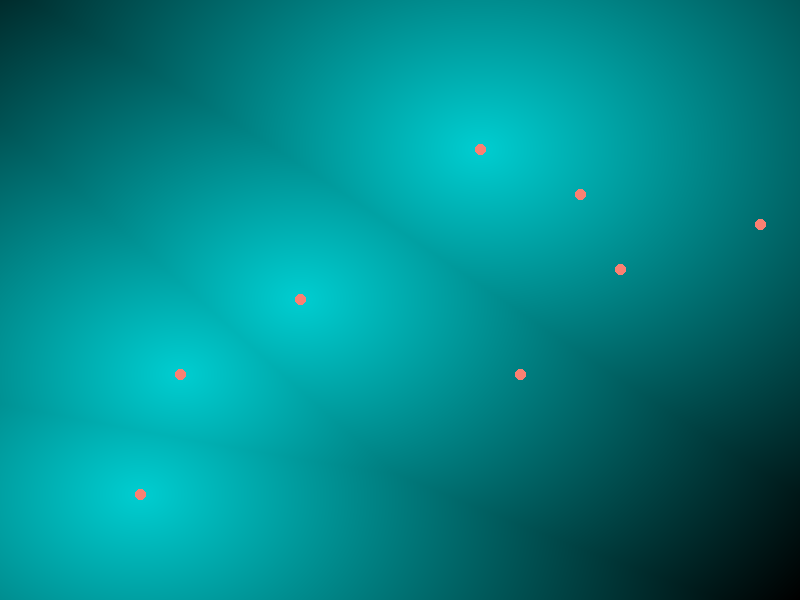

In [4]:
targets = [1, 2, 3, 4]
target_proximity_agg = proximity(points_agg, target_values=targets, distance_metric="GREAT_CIRCLE")

stack(shade(target_proximity_agg, cmap=['darkturquoise', 'black'], how='linear'),
      points_shaded)

##### Create proximity grid for all non-zero values

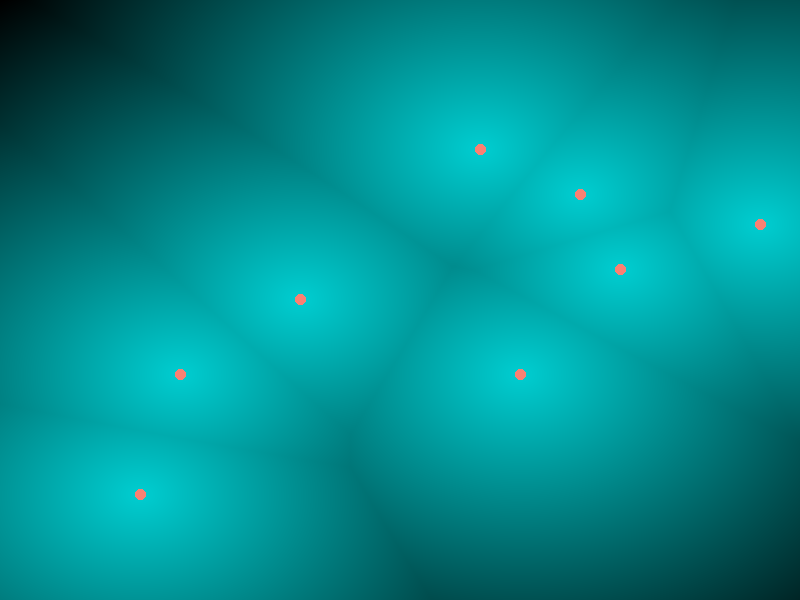

In [5]:
proximity_agg = proximity(points_agg, distance_metric="GREAT_CIRCLE")

stack(shade(proximity_agg, cmap=['darkturquoise', 'black'], how='linear'),
      points_shaded)

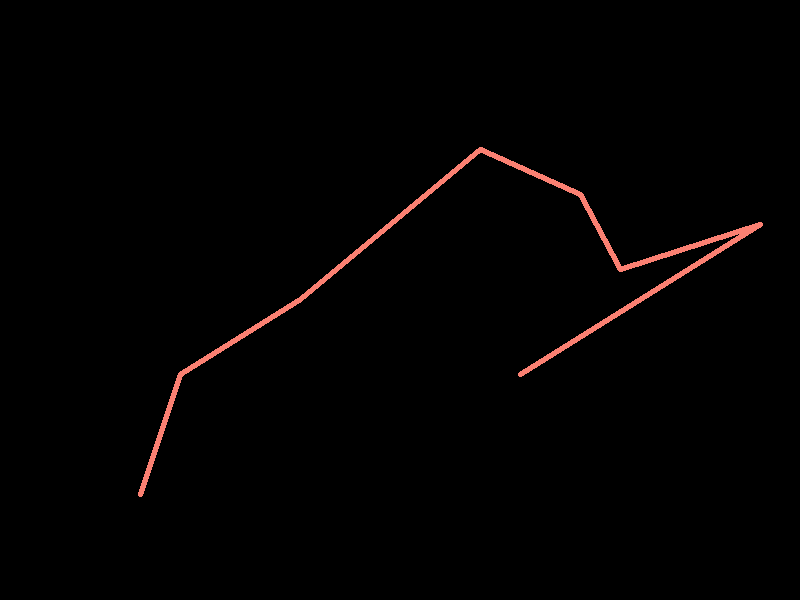

In [6]:
line_agg = cvs.line(df, x='x', y='y')
line_shaded = dynspread(shade(line_agg, cmap=['salmon',  'salmon']),
                          threshold=1,
                          max_px=2)
set_background(line_shaded, 'black')

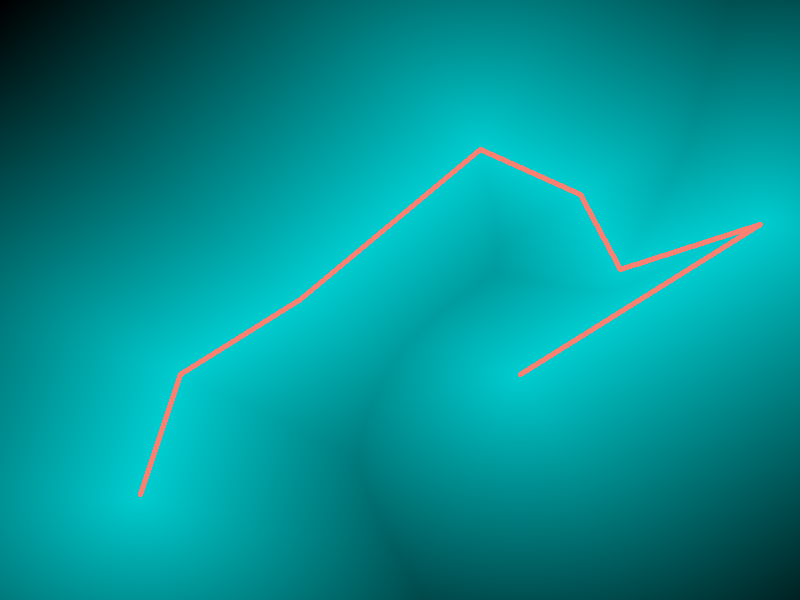

In [7]:
line_proximity = proximity(line_agg)
stack(shade(line_proximity, cmap=['darkturquoise', 'black'], how='linear'),
      line_shaded)

##### Transform Proximity DataArray
Like the other Datashader spatial tools, the result of `proximity` is an `xarray.DataArray` with a large API of potential transformations.

Below is an example of using `DataArray.where()` to apply a minimum distance and maximum distance.

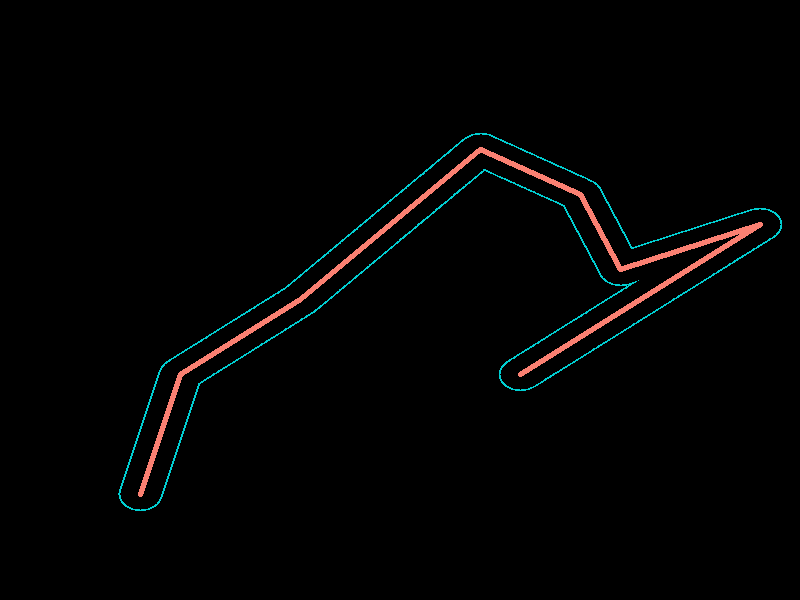

In [8]:
where_clause = (line_proximity > 1) & (line_proximity < 1.1)
proximity_shaded = shade(line_proximity.where(where_clause), cmap=['darkturquoise', 'darkturquoise'])
proximity_shaded = set_background(proximity_shaded, 'black')
stack(proximity_shaded, line_shaded)

## Proximity Allocation

Similar to `xrspatial.proximity`, the `xrspatial.allocation` function operates on a given aggregate to produce the nearest source (instead of distance to nearest source) based on target values and a distance metric. The values in the new aggregate will be the value of the nearest feature.

In the same way, you can target specific values with the `target_values` parameter.

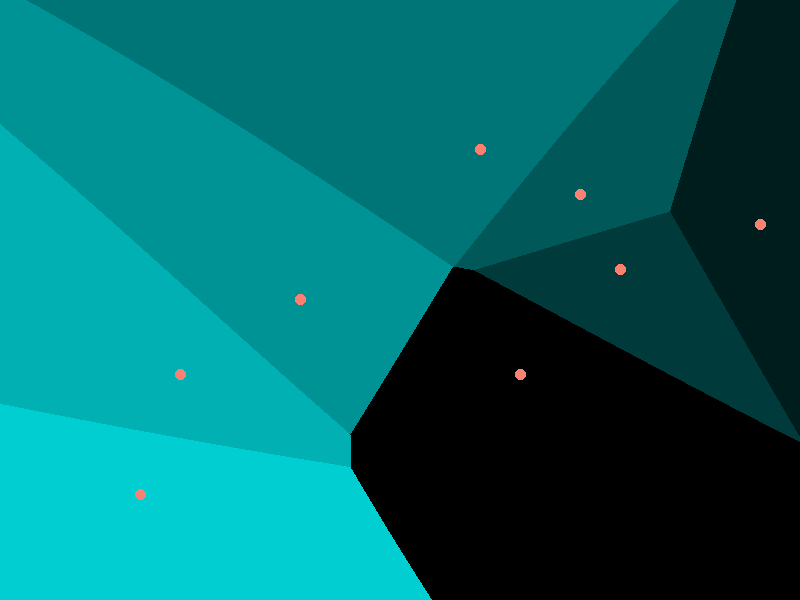

In [9]:
from xrspatial import allocation

allocation_agg = allocation(points_agg, distance_metric="GREAT_CIRCLE")
                            
stack(shade(allocation_agg, cmap=['darkturquoise', 'black'], how='linear'),
      points_shaded)

## Proximity Direction

Similar to `xrspatial.proximity`, the `xrspatial.direction` function operates on a given aggregate. It calculates for each pixel the direction to nearest source (instead of distance) based on target values and a distance metric. The output values are based on compass directions, range from 0 to 360:
- 0 is for the source cell itself
- 90 is the east
- 180 is the south
- 270 is the west
- 360 is the north

In the same way, you can target specific values with the `target_values` parameter.

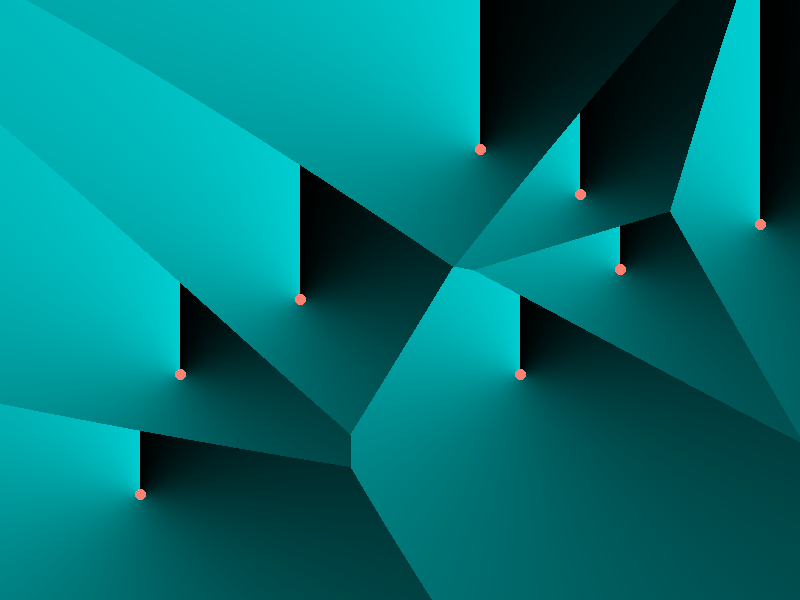

In [10]:
from xrspatial import direction

direction_agg = direction(points_agg, distance_metric="GREAT_CIRCLE")
                            
stack(shade(direction_agg, cmap=['darkturquoise', 'black'], how='linear'),
      points_shaded)




### References
An overview of the Distance toolset: https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/an-overview-of-the-distance-tools.htm